### 1. Load SIDER Data and Drug Names
Load the adverse drug reaction (ADR) dataset and the mapping between drug IDs and their names. Our raw dataset is set for analysis.

In [16]:
from pathlib import Path
import pandas as pd

In [17]:
BASE = Path().resolve()

drug_file = BASE / "drug_names.tsv"
adr_file  = BASE / "meddra_all_se.tsv"

drug_names = pd.read_csv(drug_file, sep="\t", header=None, names=["stitch_id", "drug_name"])
adr_data   = pd.read_csv(adr_file, sep="\t")  # add column names if needed

print(drug_names.head())
print(adr_data.shape)


      stitch_id                 drug_name
0  CID100000085                 carnitine
1  CID100000119        gamma-aminobutyric
2  CID100000137          5-aminolevulinic
3  CID100000143                leucovorin
4  CID100000146  5-methyltetrahydrofolate
(309848, 6)


In [18]:
adr_df = pd.read_csv(adr_file, sep='\t', header=None)
print(adr_df.head())
print(adr_df.shape)

              0             1         2    3         4                      5
0  CID100000085  CID000010917  C0000729  LLT  C0000729       Abdominal cramps
1  CID100000085  CID000010917  C0000729   PT  C0000737         Abdominal pain
2  CID100000085  CID000010917  C0000737  LLT  C0000737         Abdominal pain
3  CID100000085  CID000010917  C0000737   PT  C0687713  Gastrointestinal pain
4  CID100000085  CID000010917  C0000737   PT  C0000737         Abdominal pain
(309849, 6)


In [19]:
adr_df.columns = [
    'stitch_id',      
    'umls_id',        
    'meddra_code1',  
    'meddra_type',  
    'meddra_code2', 
    'adr_name'
]
print(adr_df)

           stitch_id       umls_id meddra_code1 meddra_type meddra_code2  \
0       CID100000085  CID000010917     C0000729         LLT     C0000729   
1       CID100000085  CID000010917     C0000729          PT     C0000737   
2       CID100000085  CID000010917     C0000737         LLT     C0000737   
3       CID100000085  CID000010917     C0000737          PT     C0687713   
4       CID100000085  CID000010917     C0000737          PT     C0000737   
...              ...           ...          ...         ...          ...   
309844  CID171306834  CID071306834     C3203358          PT     C1145670   
309845  CID171306834  CID071306834     C3665386         LLT     C3665386   
309846  CID171306834  CID071306834     C3665386          PT     C3665347   
309847  CID171306834  CID071306834     C3665596         LLT     C3665596   
309848  CID171306834  CID071306834     C3665596          PT     C0347390   

                     adr_name  
0            Abdominal cramps  
1              Abdomina

### 2. Merge Data and Clean
Combine the drug ADR info with drug names. Remove missing and duplicate entries.

In [20]:
drug_names = pd.read_csv(drug_file, sep='\t', header=None, names=['stitch_id', 'drug_name'])
df = pd.merge(adr_df, drug_names, on='stitch_id', how='left')

df = df.dropna(subset=['drug_name', 'adr_name'])

df = df.drop_duplicates(subset=['drug_name', 'adr_name'])

print(df.head())

print(df[['drug_name', 'adr_name']])

      stitch_id       umls_id meddra_code1 meddra_type meddra_code2  \
0  CID100000085  CID000010917     C0000729         LLT     C0000729   
1  CID100000085  CID000010917     C0000729          PT     C0000737   
3  CID100000085  CID000010917     C0000737          PT     C0687713   
5  CID100000085  CID000010917     C0002418         LLT     C0002418   
7  CID100000085  CID000010917     C0002871         LLT     C0002871   

                adr_name  drug_name  
0       Abdominal cramps  carnitine  
1         Abdominal pain  carnitine  
3  Gastrointestinal pain  carnitine  
5              Amblyopia  carnitine  
7                Anaemia  carnitine  
        drug_name               adr_name
0       carnitine       Abdominal cramps
1       carnitine         Abdominal pain
3       carnitine  Gastrointestinal pain
5       carnitine              Amblyopia
7       carnitine                Anaemia
...           ...                    ...
309839       K779    Vaginal haemorrhage
309841       K779

In [21]:
# ADR Frequency
adr_counts = df['adr_name'].value_counts()

print(adr_counts.head(60))


adr_name
Nausea                                                  1143
Headache                                                1068
Dermatitis                                              1042
Vomiting                                                1036
Rash                                                    1034
Dizziness                                                991
Diarrhoea                                                939
Pruritus                                                 906
Asthenia                                                 877
Hypersensitivity                                         873
Abdominal pain                                           787
Urticaria                                                764
Body temperature increased                               746
Gastrointestinal pain                                    745
Gastrointestinal disorder                                726
Pain                                                     710
Feeling abnorma

### 3. Create Features and Labels
For each drug, I calculated the number of unique ADRs (feature). Created a binary label indicating whether each drug causes the chosen target ADR.
#### I have chosen Insomnia as the target adverse drug reaction

In [22]:
target_adr = "Insomnia"
df['target_flag'] = df['adr_name'].str.contains(target_adr, case=False, na=False)

labels = df.groupby('drug_name')['target_flag'].max().reset_index()

adr_count = df.groupby('drug_name')['adr_name'].nunique().reset_index(name='num_adrs')

# Merge
final_df = pd.merge(labels, adr_count, on='drug_name')
print(final_df)

                    drug_name  target_flag  num_adrs
0                 1,25(OH)2D3         True       106
1      17-hydroxyprogesterone        False        48
2                     18F-FDG        False         7
3            18F-flutemetamol        False         9
4     2-hydroxysuccinaldehyde         True        53
...                       ...          ...       ...
1342             zolmitriptan         True       260
1343                 zolpidem         True       327
1344               zonisamide         True       272
1345                zopiclone         True       259
1346           zuclopenthixol         True       191

[1347 rows x 3 columns]


### 4. Baseline ML Models on All Drugs
I split the data in 60-40 split, then fit and evaluate both a Decision Tree and XGBoost classifier to predict whether a drug causes the target ADR, using the number of ADRs as a feature. Confusion matrices are for model results. outputs (risk_score, risk_level) are the model’s estimated probability that that drug is associated with insomnia.

Decision Tree Results
              precision    recall  f1-score   support

       False       0.67      0.75      0.71       278
        True       0.69      0.60      0.64       261

    accuracy                           0.68       539
   macro avg       0.68      0.67      0.67       539
weighted avg       0.68      0.68      0.68       539



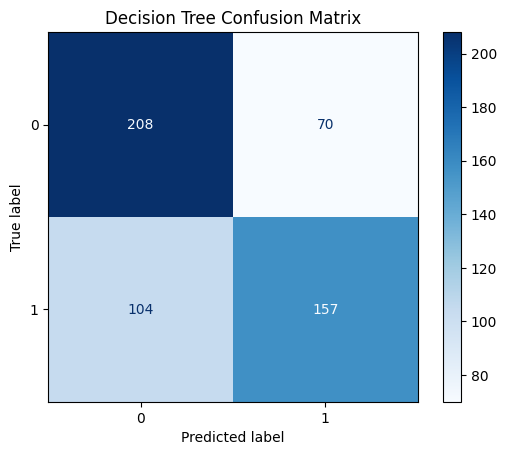

XGBoost Results
              precision    recall  f1-score   support

       False       0.73      0.71      0.72       278
        True       0.70      0.72      0.71       261

    accuracy                           0.71       539
   macro avg       0.71      0.71      0.71       539
weighted avg       0.71      0.71      0.71       539



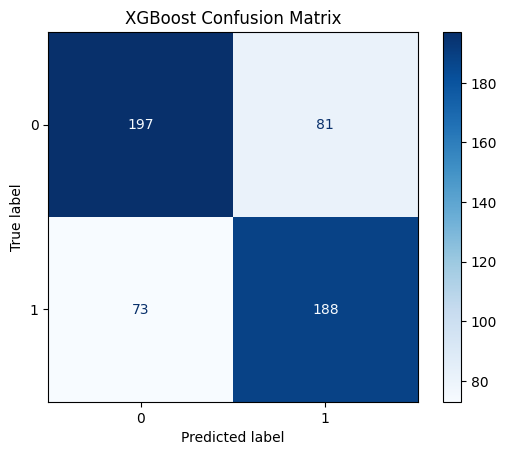

                   drug_name  risk_score_DT_base risk_level_DT_base  \
0                1,25(OH)2D3            0.857143               High   
1     17-hydroxyprogesterone            0.625000           Moderate   
2                    18F-FDG            0.000000                Low   
3           18F-flutemetamol            0.000000                Low   
4    2-hydroxysuccinaldehyde            0.500000           Moderate   
5                       4-AP            0.285714                Low   
6                      4-PBA            0.500000           Moderate   
7           4-methylpyrazole            0.500000           Moderate   
8                      5-ASA            1.000000               High   
9                       5-FU            1.000000               High   
10          5-aminolevulinic            1.000000               High   
11    5-aza-2'-deoxycytidine            1.000000               High   
12             5-azacytidine            1.000000               High   
13    

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# helper to bucket probabilities
def get_risk_level(score: float) -> str:
    if score <= 0.33:
        return "Low"
    elif score <= 0.66:
        return "Moderate"
    else:
        return "High"

# 1) train/test split on num_adrs → target_flag
X = final_df[['num_adrs']]
y = final_df['target_flag']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

# 2) Decision Tree baseline
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
print("Decision Tree Results")
print(classification_report(y_test, dt_model.predict(X_test)))

# manual confusion matrix display for DT
dt_cm = confusion_matrix(y_test, dt_model.predict(X_test))
ConfusionMatrixDisplay(dt_cm).plot(cmap='Blues')
plt.title('Decision Tree Confusion Matrix')
plt.show()

# 3) Predict probabilities for ALL drugs
dt_scores = dt_model.predict_proba(X)[:, 1]
final_df['risk_score_DT_base'] = dt_scores
final_df['risk_level_DT_base'] = [get_risk_level(s) for s in dt_scores]
final_df['classifier_base_DT'] = 'decision_tree'

# 4) XGBoost baseline
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)
print("XGBoost Results")
print(classification_report(y_test, xgb_model.predict(X_test)))

# manual confusion matrix display for XGB
xgb_pred = xgb_model.predict(X_test)
xgb_cm = confusion_matrix(y_test, xgb_pred)
ConfusionMatrixDisplay(xgb_cm).plot(cmap='Blues')
plt.title('XGBoost Confusion Matrix')
plt.show()

# 5) Predict probabilities for ALL drugs
xgb_scores = xgb_model.predict_proba(X)[:, 1]
final_df['risk_score_XGB_base'] = xgb_scores
final_df['risk_level_XGB_base'] = [get_risk_level(s) for s in xgb_scores]
final_df['classifier_base_XGB'] = 'xgboost'


# 7) Show only the requested summary columns
summary_cols = [
    'drug_name',
    'risk_score_DT_base', 'risk_level_DT_base',
    'risk_score_XGB_base','risk_level_XGB_base'
]
print(final_df[summary_cols].head(25))


### 5. Drug Clustering (Mock Patient Grouping)
Group drugs into clusters based on their ADR profiles. This simulates patient stratification—identifying drug (and by analogy, patient) subgroups with similar risk profiles. We use k-means clustering on the top 20 most common ADRs to create clusters.

In [24]:
# Drug x ADR binary matrix
drug_adr_matrix = pd.crosstab(df['drug_name'], df['adr_name'])

# Considering top 25 ADRs (columns)
top_adrs = df['adr_name'].value_counts().head(25).index
drug_adr_matrix = drug_adr_matrix[top_adrs]

# Now, drug_adr_matrix has shape (number of drugs, 25)
print(drug_adr_matrix.shape)
drug_adr_matrix


(1347, 25)


adr_name,Nausea,Headache,Dermatitis,Vomiting,Rash,Dizziness,Diarrhoea,Pruritus,Asthenia,Hypersensitivity,...,Pain,Feeling abnormal,Fatigue,Constipation,Dyspnoea,Dyspepsia,Decreased appetite,Musculoskeletal discomfort,Insomnia,Somnolence
drug_name,,,,,,,,,,,,,,,,,,,,,
"1,25(OH)2D3",1,1,1,1,1,0,1,1,1,1,...,1,0,0,1,0,0,1,1,1,1
17-hydroxyprogesterone,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,1,0,0,0,0,0
18F-FDG,0,0,1,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
18F-flutemetamol,1,1,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2-hydroxysuccinaldehyde,1,1,1,1,1,1,0,1,0,1,...,1,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zolmitriptan,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,1,1,1,1,1,1
zolpidem,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
zonisamide,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1,1,1


In [25]:
from sklearn.cluster import KMeans

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(drug_adr_matrix)

drug_adr_matrix['cluster'] = clusters

final_df = final_df.merge(drug_adr_matrix['cluster'], left_on='drug_name', right_index=True)


### 6. Model Within Each Drug Cluster (Mock Subgroup Modeling)
For each cluster, train and evaluate a Decision Tree and XGBoost model on the drugs within that cluster. Include confusion matrices to visualize model performance within each subgroup. Outputs (risk_score, risk_level) are the model’s estimated probability that that drug is associated with insomnia.


--- Per‑Cluster Results (Decision Tree) ---

Cluster 0 Classification Report:
              precision    recall  f1-score   support

       False       0.17      0.18      0.17        34
        True       0.86      0.85      0.85       196

    accuracy                           0.75       230
   macro avg       0.51      0.51      0.51       230
weighted avg       0.75      0.75      0.75       230



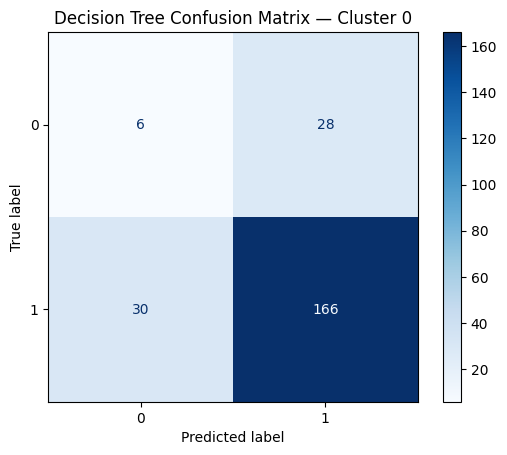


Cluster 1 Classification Report:
              precision    recall  f1-score   support

       False       0.71      0.75      0.73       127
        True       0.30      0.26      0.28        53

    accuracy                           0.61       180
   macro avg       0.51      0.51      0.51       180
weighted avg       0.59      0.61      0.60       180



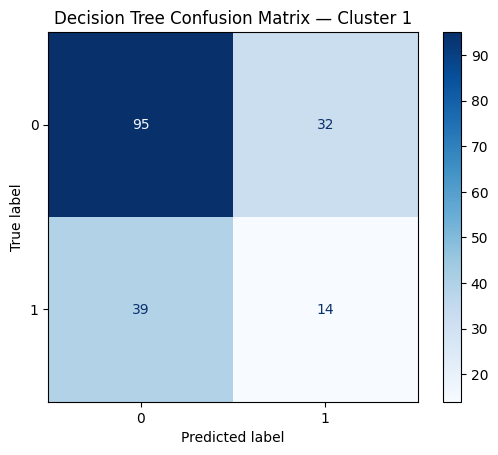


Cluster 2 Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.99      0.94       116
        True       0.00      0.00      0.00        13

    accuracy                           0.89       129
   macro avg       0.45      0.50      0.47       129
weighted avg       0.81      0.89      0.85       129



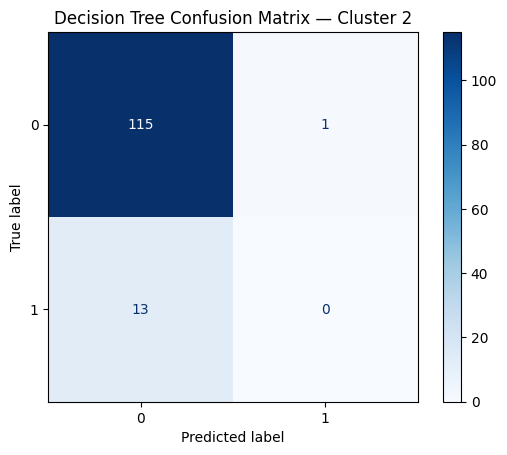


--- Per‑Cluster Results (XGBoost) ---

Cluster 0 Classification Report:
              precision    recall  f1-score   support

       False       0.24      0.15      0.18        34
        True       0.86      0.92      0.89       196

    accuracy                           0.80       230
   macro avg       0.55      0.53      0.54       230
weighted avg       0.77      0.80      0.78       230



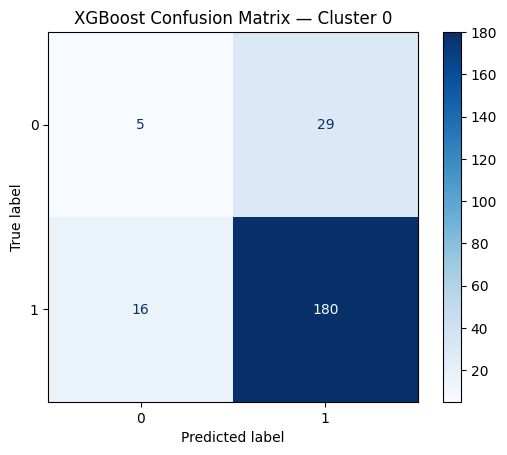


Cluster 1 Classification Report:
              precision    recall  f1-score   support

       False       0.72      0.76      0.74       127
        True       0.34      0.30      0.32        53

    accuracy                           0.62       180
   macro avg       0.53      0.53      0.53       180
weighted avg       0.61      0.62      0.62       180



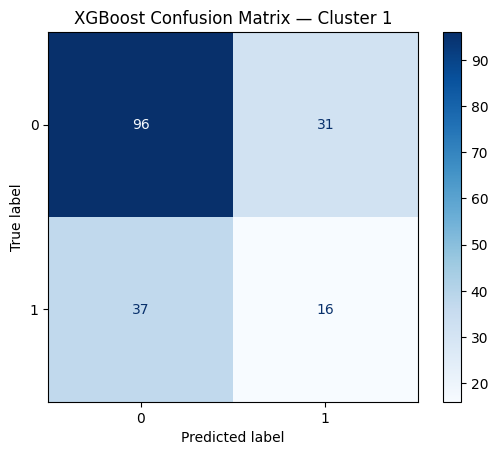


Cluster 2 Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.99      0.94       116
        True       0.00      0.00      0.00        13

    accuracy                           0.89       129
   macro avg       0.45      0.50      0.47       129
weighted avg       0.81      0.89      0.85       129



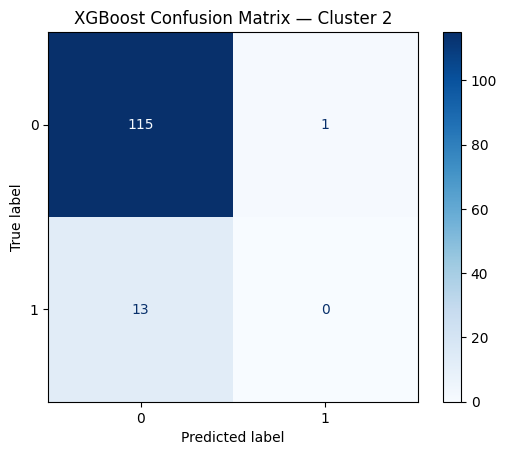

                   drug_name  cluster_id  risk_score_DT risk_level_DT  \
0                1,25(OH)2D3           0       1.000000          High   
1     17-hydroxyprogesterone           1       0.333333      Moderate   
2                    18F-FDG           2       0.000000           Low   
3           18F-flutemetamol           2       0.000000           Low   
4    2-hydroxysuccinaldehyde           1       0.250000           Low   
5                       4-AP           1       0.500000      Moderate   
6                      4-PBA           1       0.000000           Low   
7           4-methylpyrazole           1       0.272727           Low   
8                      5-ASA           0       1.000000          High   
9                       5-FU           0       1.000000          High   
10          5-aminolevulinic           1       1.000000          High   
11    5-aza-2'-deoxycytidine           0       1.000000          High   
12             5-azacytidine           0       1.00

In [31]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# helper to bucket probabilities
def get_risk_level(score: float) -> str:
    if score <= 0.33:
        return "Low"
    elif score <= 0.66:
        return "Moderate"
    else:
        return "High"

# Prepare baseline columns
for suffix in ['DT', 'XGB']:
    final_df[f'risk_score_{suffix}_base'] = np.nan
    final_df[f'risk_level_{suffix}_base'] = ""
    final_df[f'classifier_base_{suffix}'] = 'decision_tree' if suffix == 'DT' else 'xgboost'
# Add cluster_id for baseline display
final_df['cluster_id'] = final_df['cluster']

# Per‐cluster model evaluation & scoring
for model_type in ['Decision Tree', 'XGBoost']:
    suffix = 'DT' if model_type == 'Decision Tree' else 'XGB'
    print(f"\n--- Per‑Cluster Results ({model_type}) ---")
    for cluster_num in sorted(final_df['cluster'].unique()):
        cluster_df = final_df[final_df['cluster'] == cluster_num]
        if len(cluster_df) < 10 or cluster_df['target_flag'].nunique() < 2:
            print(f"Cluster {cluster_num}: skipping (insufficient data or single class)")
            continue

        # train/test split within this cluster
        Xc = cluster_df[['num_adrs']]
        yc = cluster_df['target_flag']
        X_train, X_test, y_train, y_test = train_test_split(
            Xc, yc, test_size=0.4, random_state=42
        )

        # instantiate model
        if model_type == 'Decision Tree':
            model = DecisionTreeClassifier(random_state=42)
        else:
            model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

        # fit & evaluate
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f"\nCluster {cluster_num} Classification Report:")
        print(classification_report(y_test, y_pred))

        # plot confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        ConfusionMatrixDisplay(cm).plot(cmap='Blues')
        plt.title(f"{model_type} Confusion Matrix — Cluster {cluster_num}")
        plt.show()

        # score ALL drugs in this cluster
        scores = model.predict_proba(cluster_df[['num_adrs']])[:, 1]
        final_df.loc[cluster_df.index, f'risk_score_{suffix}_base'] = scores
        final_df.loc[cluster_df.index, f'risk_level_{suffix}_base'] = [
            get_risk_level(s) for s in scores
        ]

# Show summary
summary_cols = [
    'drug_name',
    'cluster_id',
    'risk_score_DT', 'risk_level_DT',
    'risk_score_XGB','risk_level_XGB'
]
print(final_df[summary_cols].head(25))
